In [9]:
import scipy.optimize as optimize
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np

#import minifim
#import proflike

from scipy.integrate import odeint as ode


import numpy as np

def f(x, δt, params):
    s, i, r = x

    μ = 0
    β = params["beta"]
    γ = params["gamma"]

    λ = β*i

    sdot = μ - λ * s - μ * s     # S
    idot = λ * s - γ * i - μ * i # I
    rdot = γ * i - μ*r           # R

    return np.array([sdot, idot, rdot])

def f0(params, data):
	S0 = 1.0 - (data[0]/params["rho"])
	I0 = data[0]/params["rho"]
	R0 = 0.0
	X0 = [S0, I0, R0]
	return X0

def g(res, params):
	ρ = params["rho"]
	return res[:,1] * ρ

def loglklhd(params, obs_data, times):
	params = np.abs(params)
	data   = np.array(obs_data)
	x0     = f0(params, obs_data)
	res    = ode(f, x0, times, args=(params,))
	y      = g(res, params)

    # negative log likelihood (for minimization)
	nll    = sum(y) - sum(data*np.log(y))
	return nll


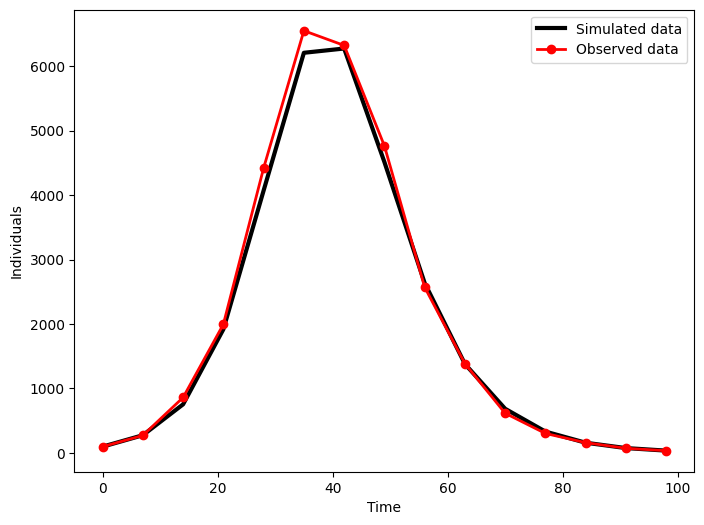

In [14]:
times = [0, 7, 14, 21, 28, 35, 42, 49, 56, 63, 70, 77, 84, 91, 98]
data  = [97, 271, 860, 1995, 4419, 6549, 6321, 4763, 2571, 1385, 615, 302, 159, 72, 34]

params   = {"beta": 0.4, "gamma": 0.25, "rho": 80000}
x0       = f0(params,data)

y_sim    = ode(f, x0, times, args=(params,))
sim_data = g(y_sim, params)

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(times, sim_data, 'k', linewidth=3, label='Simulated data')
ax.plot(times, data, 'r-o', linewidth=2, label='Observed data')
ax.set_xlabel('Time')
ax.set_ylabel('Individuals')
plt.legend()


In [26]:
# fisher information matrix
def fim(times, params, data, delta = 0.001):

    listX    = []
    params_1 = params.copy()
    params_2 = params.copy()

    for k in list(params.keys()):

        params_1[k] = params[k] * (1+delta)
        params_2[k] = params[k] * (1-delta)

        x01   = f0(params_1, data)
        x02   = f0(params_2, data)

        res_1    = ode(f, x01, times, args=(params_1,))
        res_2    = ode(f, x02, times, args=(params_2,))

        sim_dat1 = g(res_1, params_1)
        sim_dat2 = g(res_2, params_2)
        subX     = (sim_dat1 - sim_dat2) / (2 * delta * params[k])

        listX.append(subX.tolist())

    X   = np.matrix(listX)
    FIM = np.dot(X, X.transpose())
    return FIM


<Axes: >

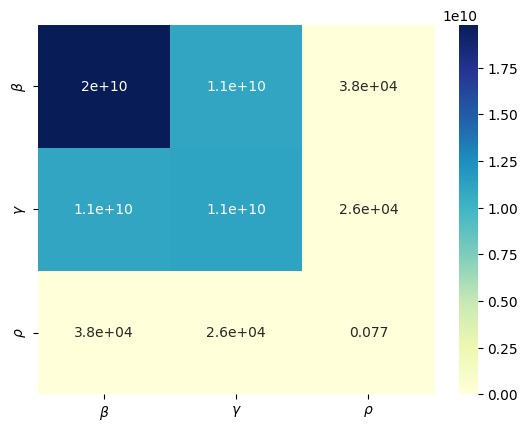

In [34]:
import seaborn as sns
import pandas as pd

cols   = [r"$\beta$", r"$\gamma$", r"$\rho$"]
fim_np = fim(times, params, data, delta = 0.001)
fim_df = pd.DataFrame(fim_np, index=cols, columns=cols)
sns.heatmap(fim_df, annot=True, cmap="YlGnBu")


In [65]:
beta_search  = np.linspace(0.2, 0.8, 500)
gamma_search = np.linspace(1/7, 1/3, 500)

param_search = params.copy()

eigs_fim = np.full((len(params), len(beta_search), len(gamma_search)), np.nan)
det_fim = np.full((len(beta_search), len(gamma_search)), np.nan)

for ib, beta in enumerate(beta_search):
    for ig, gamma in enumerate(gamma_search):
        param_search["beta"]  =  beta
        param_search["gamma"] = gamma
        fim_np                = fim(times, param_search, data, delta = 0.001)
        eigs_fim[0, ib, ig], eigs_fim[1, ib, ig], eigs_fim[2, ib, ig]   = np.linalg.eigvals(fim_np)

        det_fim[ib, ig]       = np.linalg.det(fim_np)

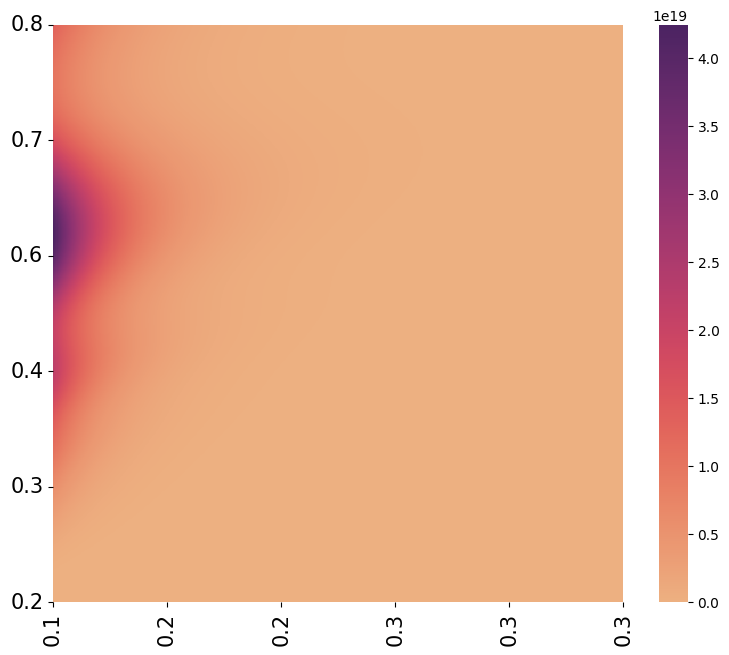

In [69]:
det_fim_df = pd.DataFrame(det_fim, index=beta_search, columns=gamma_search)
palette     = sns.color_palette("flare", as_cmap=True)

fig, ax = plt.subplots(1, 1, figsize=(9.2, 7.5), sharey="col", sharex="col")
sns.heatmap(ax = ax, data=det_fim_df.iloc[::-1], cmap=palette,  cbar=True)

xticks         = det_fim_df.columns
keptxticksidx  = np.linspace(0,len(xticks),6)
xtickslabels   = list(xticks[ np.maximum(keptxticksidx.astype(int)-1,0) ])
xtickslabels   = ['{:.1f}'.format(l) for l in xtickslabels]

yticks         = det_fim_df.iloc[::-1].index
keptyticksidx  = np.linspace(0,len(yticks),6)
ytickslabels   = list(yticks[ np.maximum(keptyticksidx.astype(int)-1,0) ])
ytickslabels   = ['{:.1f}'.format(l) for l in ytickslabels]

ax.set_xticks(keptxticksidx)
ax.set_yticks(keptyticksidx)

ax.set_xticklabels(xtickslabels, fontsize=20, rotation=0)
ax.set_yticklabels(ytickslabels, fontsize=20)

ax.tick_params( which='both', axis='x', labelrotation=90, labelsize=15)
ax.tick_params( which='both', axis='both', labelsize=15)

#ax.set_xlabel(r"$\mathcal{R}_E=\theta/\kappa \cdot 1/(\tau+\delta)$", fontsize=20)
#ax.set_ylabel(r"$\mathcal{R}_H=\beta/(\tau+\delta)$", fontsize=20)

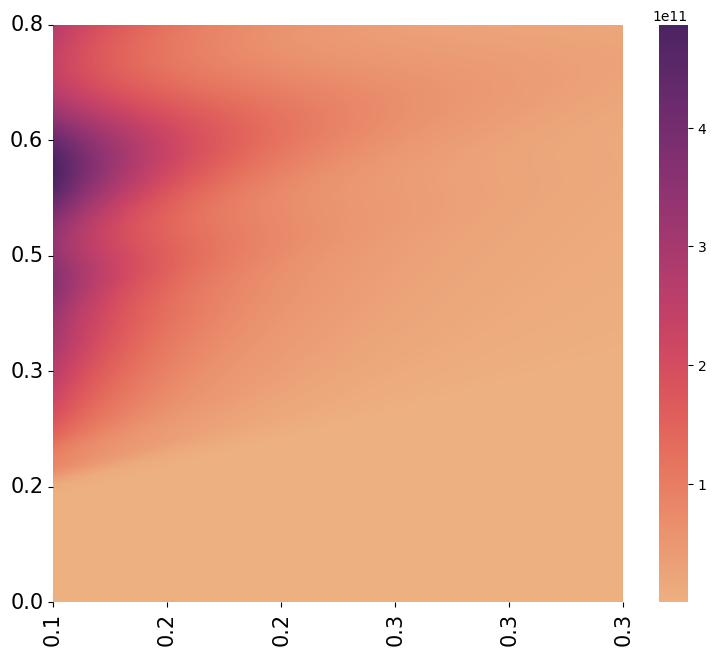

In [63]:
eig_beta_df = pd.DataFrame(eigs_fim[0, :, :], index=beta_search, columns=gamma_search)
palette     = sns.color_palette("flare", as_cmap=True)

fig, ax = plt.subplots(1, 1, figsize=(9.2, 7.5), sharey="col", sharex="col")
sns.heatmap(ax = ax, data=eig_beta_df.iloc[::-1], cmap=palette,  cbar=True)

xticks        = eig_beta_df.columns
keptxticksidx = np.linspace(0,len(xticks),6)
xtickslabels  = list(xticks[ np.maximum(keptxticksidx.astype(int)-1,0) ])
xtickslabels  = ['{:.1f}'.format(l) for l in xtickslabels]

yticks         = eig_beta_df.iloc[::-1].index
keptyticksidx  = np.linspace(0,len(yticks),6)
ytickslabels   = list(yticks[ np.maximum(keptyticksidx.astype(int)-1,0) ])
ytickslabels   = ['{:.1f}'.format(l) for l in ytickslabels]

ax.set_xticks(keptxticksidx)
ax.set_yticks(keptyticksidx)

ax.set_xticklabels(xtickslabels, fontsize=20, rotation=0)
ax.set_yticklabels(ytickslabels, fontsize=20)

ax.tick_params( which='both', axis='x', labelrotation=90, labelsize=15)
ax.tick_params( which='both', axis='both', labelsize=15)

#ax.set_xlabel(r"$\mathcal{R}_E=\theta/\kappa \cdot 1/(\tau+\delta)$", fontsize=20)
#ax.set_ylabel(r"$\mathcal{R}_H=\beta/(\tau+\delta)$", fontsize=20)